<a href="https://colab.research.google.com/github/maaniaxs/Deep-Learning/blob/main/SkimLit_NLP_31_11_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# DOWNLOAD THE DATASET
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

#
# Preprocess data

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads a text file and returns the lines of text as a list."""
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# let's the train text lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:3], len(train_lines)  # count the length of the sentences

(['###24293578\n',
  'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n'],
 210040)

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data for making a dataframe of this text data"""
  
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 484 ms, sys: 110 ms, total: 594 ms
Wall time: 597 ms


(180040, 30212, 30135)

In [ ]:
# Make a DataFrame 
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head(7)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

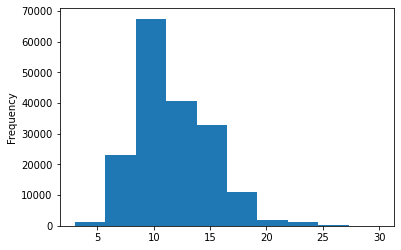

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df['text'][:115000].tolist()
val_sentences = val_df['text'][:20000].tolist()
test_sentences = test_df['text'][:20000].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(115000, 20000, 20000)

In [ ]:
# view the 10 lines of training sentences
train_sentences[:4]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .']

In [ ]:
# Make numeric labels (ML models require numeric labels)
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'][:115000].to_numpy().reshape(-1,1))
# 
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'][:20000].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'][:20000].to_numpy().reshape(-1,1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

# LabelEncoder

In [ ]:
# Extract labels (target columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoded = LabelEncoder()
train_labels_encoded = label_encoded.fit_transform(train_df['target'][:115000].to_numpy())
val_labels_encoded = label_encoded.fit_transform(val_df['target'][:20000].to_numpy())
test_labels_encoded = label_encoded.fit_transform(test_df['target'][:20000].to_numpy())
len(train_labels_encoded), train_labels_encoded

(115000, array([3, 2, 2, ..., 4, 4, 4]))

In [ ]:
# Get classes name and number of classes from LabelEncoder
num_classes = len(label_encoded.classes_)
class_names = label_encoded.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Experiment                       Model
*  0            Naive Bayes with TF-IDF encoder(baseline)
*  1            Conv1D with token token_embeddings
*  2            Tensorflow Hub Pretrained Feature Extracter
*  3            Conv1D with character embeddings
*  4            Pretrained token embeddings (same as 2) + character embeddings (same as 3)
*  5            Pretrained tokenembeddings + character embeddings + positional embeddings

In [ ]:
# STARTING A SERIES MODEL EXPERIMENTS

In [ ]:
from sklearn.metrics import *
def calculate_results(y_true, y_pred):
  """ Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
## Model 0: Getting a Baseline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
# create a pipeline
model_0 = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])
# Fit the baseline model_0
model_0.fit(X = train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf_idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Make prediction of baseline model_0
from sklearn.metrics import *

baseline_pred = model_0.predict(val_sentences)
print('accuracy_score = ', accuracy_score(val_labels_encoded, baseline_pred))
#print('f1_score = ', f1_score(val_labels_encoded, baseline_pred))

accuracy_score =  0.7218323844829869


In [ ]:
# baseline reults
calculate_results(val_labels_encoded, baseline_pred)

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# model_2, Building & fitting an NLP feature extraction model using pretrained embeddings

In [ ]:
!pip install tensorflow_hub
import keras
import tensorflow as tf
from keras import layers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Now let'ss use pretrained word embeddings from Tensorflow Hub (https://tfhub.dev/google/universal-sentence-encoder/4)
# Download pretrained Tensorflow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', trainable=False, name = 'universal_sentence_encoder')

In [ ]:
# test out the pretrained embedding on a random sentence  # EXAMPLE
import random
random_train_sentence = random.choice(train_sentences)
embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
len(embedded_sentence[0])

512

In [ ]:
# Define feature extraction model using TF Hub
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text & create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax')(x) # create output layer

model_2 = keras.Model(inputs, outputs, name='model_2_USE_feature_extraction')

In [ ]:
# compile the model_2
model_2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model_2.summary()

In [ ]:
train_sent = train_df['text'][:115000]
val_sent = val_df['text'][:20000]
test_sent = test_df['text'][:20000]
len(train_sent), len(val_sent), len(test_sent)

(115000, 20000, 20000)

In [ ]:
# fit the model_2 
model_2.fit(train_sent, train_labels_one_hot, epochs=5, validation_data=(test_sent, test_labels_one_hot), batch_size=64)

Epoch 1/5
1797/1797 [==============================] - 62s 34ms/step - loss: 0.7082 - accuracy: 0.7287 - val_loss: 0.6678 - val_accuracy: 0.7466
Epoch 2/5
1797/1797 [==============================] - 63s 35ms/step - loss: 0.6329 - accuracy: 0.7585 - val_loss: 0.6461 - val_accuracy: 0.7532
Epoch 3/5
1797/1797 [==============================] - 53s 29ms/step - loss: 0.5973 - accuracy: 0.7726 - val_loss: 0.6335 - val_accuracy: 0.7593
Epoch 4/5
1797/1797 [==============================] - 52s 29ms/step - loss: 0.5702 - accuracy: 0.7839 - val_loss: 0.6306 - val_accuracy: 0.7619
Epoch 5/5
1797/1797 [==============================] - 50s 28ms/step - loss: 0.5496 - accuracy: 0.7922 - val_loss: 0.6291 - val_accuracy: 0.7604


In [ ]:
# Turn our data into Tensorflow Datasets
train_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
test_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
val_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
train_data = train_data.batch(32).prefetch(tf.data.AUTOTUNE)  # turn them into prefetch dataset, also work without prefetch 
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_2.fit(train_data, epochs=4, validation_data=test_data )  # SECOND= this is run so slow with tensorflow data

Epoch 1/4
3125/3125 [==============================] - 56s 18ms/step - loss: 0.5191 - accuracy: 0.8044 - val_loss: 0.6416 - val_accuracy: 0.7589
Epoch 2/4
3125/3125 [==============================] - 51s 16ms/step - loss: 0.5025 - accuracy: 0.8110 - val_loss: 0.6471 - val_accuracy: 0.7567
Epoch 3/4
3125/3125 [==============================] - 50s 16ms/step - loss: 0.4867 - accuracy: 0.8171 - val_loss: 0.6558 - val_accuracy: 0.7563
Epoch 4/4
3125/3125 [==============================] - 51s 16ms/step - loss: 0.4721 - accuracy: 0.8229 - val_loss: 0.6669 - val_accuracy: 0.7551


In [ ]:
# THIRD=This method run so fast compare to above fit method
model_2.fit(train_data, epochs=4, validation_data = test_data, 
            steps_per_epoch=int(0.1 * len(train_data)), validation_steps=int(0.1*len(test_data)) )

Epoch 1/4
312/312 [==============================] - 7s 18ms/step - loss: 0.4813 - accuracy: 0.8203 - val_loss: 0.7083 - val_accuracy: 0.7371
Epoch 2/4
312/312 [==============================] - 7s 23ms/step - loss: 0.4454 - accuracy: 0.8306 - val_loss: 0.7272 - val_accuracy: 0.7337
Epoch 3/4
312/312 [==============================] - 6s 19ms/step - loss: 0.4798 - accuracy: 0.8213 - val_loss: 0.7051 - val_accuracy: 0.7344
Epoch 4/4
312/312 [==============================] - 5s 16ms/step - loss: 0.4733 - accuracy: 0.8204 - val_loss: 0.7164 - val_accuracy: 0.7385


In [ ]:
# Make prediction with model_2
model_2_pred = model_2.predict(val_data)
model_2_pred = tf.argmax(model_2_pred, axis=1)
model_2_pred

469/469 [==============================] - 6s 13ms/step


<tf.Tensor: shape=(15000,), dtype=int64, numpy=array([0, 0, 3, ..., 1, 0, 0])>

In [ ]:
model_2_results = calculate_results(val_labels_encoded, model_2_pred)
model_2_results

{'accuracy': 75.98,
 'precision': 0.7595303859375385,
 'recall': 0.7598,
 'f1': 0.756414196409213}

# Model_4 : Building a multi input model 

In [ ]:
# CREATING CHARACTER-LEVEL TOKENIZER
# Make a function to split sentences into characters
def split_char(text):
  return ' '.join(list(text))

# text splitting
train_chars = [split_char(sentence) for sentence in train_sent]
val_chars = [split_char(sentence) for sentence in val_sent]
test_chars = [split_char(sentence) for sentence in test_sent]
train_chars[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

# Create char-level token-vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

char_tokens = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens = char_tokens, output_sequence_length = 290, name='char_vectorizer')

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)
char_vocab = char_vectorizer.get_vocabulary()
print(len(char_vocab))

28


In [ ]:
# Creating Embedding , # Create char embedding layer
char_embed = keras.layers.Embedding(input_dim= char_tokens, # number of different characters
                              output_dim=25, # 
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

In [ ]:
# 1. create token-level embedding model
# 2. Create char-level model
# 3. Combine 1 & 2 with a (layers.Concatenate)
# 4. Build a series of output layers on top of 3 similar

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inptus')
token_embedding = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embedding)
token_model = tf.keras.Model(inputs=token_inputs, outputs= token_outputs)

# 2. Setup char input/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embedding)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char output
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# 4. Create a output layer
combined_dropout = layers.Dropout(0.3)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
output_layer = layers.Dense(5, activation='softmax')(combined_dense)

# 5. Construct a final model_4
model_4 = tf.keras.Model(inputs= [token_model.input, char_model.input], outputs= output_layer, name= 'model_4')


In [ ]:
# plot model_4
from keras.utils import plot_model
plot_model(model_4)

In [ ]:
# compile model_4
model_4.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

In [ ]:
# combining data for model_4
# Training dataset
train_char_data = tf.data.Dataset.from_tensor_slices((train_sent, train_chars)) # (train_sentences,train_chars) this data order according constructed model_4
train_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_dataset = tf.data.Dataset.zip((train_char_data, train_char_labels)) # combine input & target data with tf.data.Dataset.zip method

train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# test dataset
test_char_data = tf.data.Dataset.from_tensor_slices((test_sent, test_chars))
test_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_dataset = tf.data.Dataset.zip((test_char_data, test_char_labels)) # 

test_char_dataset = test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_4.fit(train_char_dataset, steps_per_epoch= int(0.1*len(train_char_dataset)), validation_steps= int(0.1*len(test_char_dataset)),
            epochs=5, validation_data= test_char_dataset)

Epoch 1/5
359/359 [==============================] - 99s 250ms/step - loss: 0.9815 - accuracy: 0.6121 - val_loss: 0.8116 - val_accuracy: 0.6875
Epoch 2/5
359/359 [==============================] - 92s 255ms/step - loss: 0.7736 - accuracy: 0.7023 - val_loss: 0.7623 - val_accuracy: 0.7107
Epoch 3/5
359/359 [==============================] - 84s 233ms/step - loss: 0.7334 - accuracy: 0.7134 - val_loss: 0.7138 - val_accuracy: 0.7258
Epoch 4/5
359/359 [==============================] - 81s 226ms/step - loss: 0.7146 - accuracy: 0.7244 - val_loss: 0.6980 - val_accuracy: 0.7308
Epoch 5/5
359/359 [==============================] - 82s 228ms/step - loss: 0.7118 - accuracy: 0.7255 - val_loss: 0.6826 - val_accuracy: 0.7424


In [ ]:
# Make prediction
model_4_pred = model_4.predict(test_char_dataset)
model_4_pred = tf.argmax(model_4_pred, axis=1)
model_4_pred

625/625 [==============================] - 36s 56ms/step


<tf.Tensor: shape=(20000,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 2])>

In [ ]:
# get results of model_4
model_4_results = calculate_results(test_labels_encoded, model_4_pred)
model_4_results

{'accuracy': 73.42999999999999,
 'precision': 0.7294878911483774,
 'recall': 0.7343,
 'f1': 0.726960954205618}

# Model_5 Pretrained-token-Embedding + charachter-Embedding + positional-Embeddings 

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


# Create Positional Embedding

In [ ]:
# how many different value in line_number column 
len(train_df['line_number'].value_counts())

31

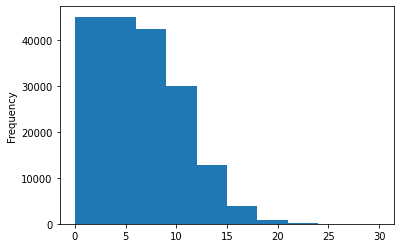

In [ ]:
# check distribution
train_df.line_number.plot.hist()

In [ ]:
# Use tensorflow to create one-hot encoded tensors of our 'line_number'
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'][:115000].to_numpy(), depth=16)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'][:20000].to_numpy(), depth=16)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'][:20000].to_numpy(), depth=16)

train_line_numbers_one_hot.shape, val_line_numbers_one_hot.shape, train_line_numbers_one_hot[:3]

(TensorShape([115000, 16]),
 TensorShape([20000, 16]),
 <tf.Tensor: shape=(3, 16), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>)

In [ ]:
# Now we have encoded our line_numbers feature, let's do the same of our total_lines_number.
len(train_df['total_lines'].value_counts())   # checking length of different numbers in 'total_lines'

27

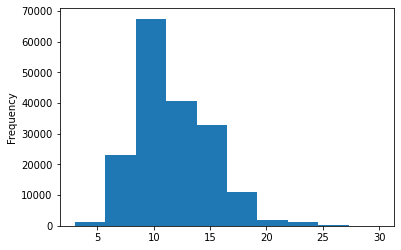

In [ ]:
train_df['total_lines'].plot.hist()  # check the distribution

In [ ]:
# Use tensorflow to create one-hot encoded tensors of our 'total_lines' feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'][:115000].to_numpy(), depth=19)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'][:20000].to_numpy(), depth=19)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'][:20000].to_numpy(), depth=19)

train_total_lines_one_hot.shape, val_total_lines_one_hot.shape, test_total_lines_one_hot[:3]

(TensorShape([115000, 19]),
 TensorShape([20000, 19]),
 <tf.Tensor: shape=(3, 19), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]], dtype=float32)>)

In [ ]:
#  BUILDING A MODEL_5 with combining the Four inputs
# 1. Create a token-level model
# 2. Create a character-level model
# 3. Create a model for the 'line_number' feature
# 4. Create a model for the 'total_lines' feature
# 5. Create the outputs of 1 & 2 using tf.keras.layers.Concatenate
# 6. Combine the outputs of 3,4, 5 using tf.keras.layers.Concatenate
# 7. Combine the inputs of 1,2, 3, 4 and outputs 

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype= tf.string, name='token_inptus')
token_embedding = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embedding)
token_model = tf.keras.Model(inputs=token_inputs, outputs= token_outputs)
# 2. char input
char_inputs = layers.Input(shape=(1,), dtype= tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32,))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs= char_bi_lstm)

# 3. line_number model
line_number_inputs = layers.Input(shape=(16,), dtype=tf.float32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs= x)
# 4 Total_line model
total_lines_inputs = layers.Input(shape=(19,), dtype= tf.float32, name= 'total_lines_inputs')
y = layers.Dense(32, activation= 'relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs= total_lines_inputs, outputs= y)

# 5. Combine token & char model
combined_embedding = layers.Concatenate(name= 'char_token_hybrid_embedding')([token_model.output, char_model.output])
z = layers.Dense(256, activation='relu')(combined_embedding)
z = layers.Dropout(0.3)(z)
# 6. Combine positional embedding with combined token & char embeddings.
tribrid_combined = layers.Concatenate(name= 'char_token_positional_embedding')([line_number_model.output, total_lines_model.output, z])

output_layer = layers.Dense(5, activation='softmax', name='output_layer')(tribrid_combined)
model_5 = tf.keras.Model(inputs= [token_inputs,
                                  char_inputs,
                                  line_number_inputs,
                                  total_lines_inputs ], outputs= output_layer,)

# model_5 = tf.keras.Model(inputs=[line_number_model.inputs, total_lines_model.inputs, token_model.inputs, char_model.inputs],
#                         outputs= output_layer)

In [ ]:
# 
# model_5.summary()
# plot model_5
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
# compile model_5
model_5.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer= 'adam', metrics=['accuracy'])

In [ ]:
# Create tensorflow dataset for model_5
# creating training & validation dataset

train_model_5_data = tf.data.Dataset.from_tensor_slices(( train_sentences, train_chars,
                                                         train_line_numbers_one_hot,
                                                         train_total_lines_one_hot))
train_model_5_label = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_model_5_dataset = tf.data.Dataset.zip((train_model_5_data, train_model_5_label))
train_model_5_dataset = train_model_5_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_model_5_data = tf.data.Dataset.from_tensor_slices(( val_sentences, val_chars,
                                                       val_line_numbers_one_hot, # Validation data
                                                         val_total_lines_one_hot,))
val_model_5_label = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_model_5_dataset = tf.data.Dataset.zip((val_model_5_data, val_model_5_label))
val_model_5_dataset = val_model_5_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_model_5_dataset, val_model_5_dataset

In [ ]:
history = model_5.fit(train_model_5_dataset,
                      steps_per_epoch= int(0.1*len(train_model_5_dataset)),epochs=2,
                      validation_data= val_model_5_dataset,
                      validation_steps= int(0.1*len(val_model_5_dataset)))

Epoch 1/2
359/359 [==============================] - 81s 224ms/step - loss: 0.9641 - accuracy: 0.8138 - val_loss: 0.9533 - val_accuracy: 0.8261
Epoch 2/2
359/359 [==============================] - 84s 234ms/step - loss: 0.9347 - accuracy: 0.8381 - val_loss: 0.9501 - val_accuracy: 0.8271


In [ ]:
model_5_pred = model_5.predict(val_model_5_dataset)
model_5_pred = tf.argmax(model_5_pred, axis=1)
model_5_pred

625/625 [==============================] - 33s 52ms/step


<tf.Tensor: shape=(20000,), dtype=int64, numpy=array([0, 0, 3, ..., 2, 2, 2])>

In [ ]:
model_5_results = calculate_results(val_labels_encoded, model_5_pred)
model_5_results

{'accuracy': 82.525,
 'precision': 0.8291903305932797,
 'recall': 0.82525,
 'f1': 0.8219589881306556}

In [ ]:
model_4_results 

{'accuracy': 73.42999999999999,
 'precision': 0.7294878911483774,
 'recall': 0.7343,
 'f1': 0.726960954205618}

In [ ]:
# I got more accuracy with model_5 compare to another models results